# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install meteostat

In [3]:
from sklearn.preprocessing import LabelEncoder

In [22]:
import os
import glob
import time
import numpy as np
import pandas as pd
from geopy.distance import distance
import datetime as datetime
from multiprocessing import Process, Manager
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import plotly.graph_objects as go
import holidays
from meteostat import Point, Hourly, Stations

us_holidays = holidays.country_holidays('US')

directory = '/content/drive/MyDrive/Thesis/'


data_dir = directory + "Data/"

# Read CSV

In [5]:
#!unzip "/content/drive/MyDrive/Colab Notebooks/GBDS_Project/raw_data/202106-baywheels-tripdata.zip"

In [6]:
from shapely.geometry import Point, Polygon

# Define the polygon for Manhattan (approximate boundaries)
manhattan_polygon = Polygon([
    (-73.926300, 40.877671),
    (-73.922994, 40.877227),
    (-73.920024, 40.875224),
    (-73.916280, 40.874640),
    (-73.914403, 40.874510),
    (-73.911626, 40.873464),
    (-73.910370, 40.872291),
    (-73.909903, 40.870698),
    (-73.914040, 40.864194),
    (-73.916533, 40.860966),
    (-73.925260, 40.850602),
    (-73.929904, 40.843885),
    (-73.933885, 40.835120),
    (-73.933885, 40.828478),
    (-73.933145, 40.819519),
    (-73.933528, 40.809380),
    (-73.928220, 40.801866),
    (-73.928629, 40.795008),
    (-73.938756, 40.784106),
    (-73.940773, 40.774839),
    (-73.951841, 40.762962),
    (-73.968080, 40.745712),
    (-73.969998, 40.721783),
    (-73.976165, 40.708818),
    (-73.993777, 40.706617),
    (-74.009752, 40.698527),
    (-74.019027, 40.699648),
    (-74.022106, 40.705039),
    (-74.011532, 40.755631),
    (-74.001283, 40.775638),
    (-73.931169, 40.879602),
    (-73.926300, 40.877671)   # Closing the polygon
])

def is_in_manhattan(lat, lon, polygon):
    point = Point(lon, lat)
    return polygon.contains(point)

centroids = pd.read_csv(data_dir+"centroids.csv")
centroid_stations = pd.read_csv(data_dir+"station_centroids.csv")
standard_stations = pd.read_csv(data_dir+"standard_centroids.csv")

In [7]:
standard_stations['station_id'] = standard_stations['station_id'].astype(str)

In [8]:
def aggregate_data(raw_data):

  print("starting data")
  raw_data['started_at'] = pd.to_datetime(raw_data['started_at'])
  raw_data['ended_at'] = pd.to_datetime(raw_data['ended_at'])
  raw_data['duration_sec'] = (raw_data['ended_at'] - raw_data['started_at'])/ pd.Timedelta(seconds=1)

  df = approximate_stations(raw_data)
  print("Stations approximated")

  df_final = dropping_trips_depending_on_time(df)
  print("Dropping Trips")

  df_final['start_station_id'] = df_final['start_station_id'].astype(str)
  df_final['end_station_id'] = df_final['end_station_id'].astype(str)
  # Change Datatypes and dropping columns
  df_final = df_final.dropna(subset=['start_station_id', 'end_station_id']).drop([
      'rideable_type',
      'member_casual',
      'start_approx',
      'start_approx_distance',
      'end_approx',
      'end_approx_distance'
      ],
    axis=1)

  print("Dropped columns")

  df_final['ended_at'] = pd.to_datetime(df_final['ended_at'])
  df_final['started_at'] = pd.to_datetime(df_final['started_at'])


  df_final = merge_station_data(df_final)

  column_name='started_at'
  conversion_dict_hourly = dict(year= df_final[f'{column_name}_year'],
                                month=df_final[f'{column_name}_month'],
                                day=  df_final[f'{column_name}_day'],
                                hour= df_final[f'{column_name}_hour']
                                )

  df_final[f'{column_name}_hourly'] = pd.to_datetime(conversion_dict_hourly)

  demand_hourly, demand_hourly_overall, return_hourly, return_hourly_overall = get_aggregates(df_final)

  return demand_hourly, demand_hourly_overall, return_hourly, return_hourly_overall

In [9]:
le = LabelEncoder()

le.fit(standard_stations['station_id'])

import pickle
with open(data_dir+'station_encoder.pkl', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Approximate_stations

In [10]:
def approximate_stations(raw_data):

  df_missing_stations = raw_data[(raw_data['start_station_id'].isna()) |\
                                  (raw_data['end_station_id'].isna())].copy()

  df_existing_stations = raw_data[~((raw_data['start_station_id'].isna()) |\
                                      (raw_data['end_station_id'].isna()))].copy()

  del raw_data

  df_missing_start_stations_no_duplicates = df_missing_stations.drop_duplicates(
                                          subset=['start_lat', 'start_lng']).copy()\
                                              .reset_index(drop=True)

  df_missing_start_stations_no_duplicates = df_missing_start_stations_no_duplicates[
                                              df_missing_start_stations_no_duplicates['start_station_id'].isna()].copy()\
                                              .reset_index(drop=True)

  df_missing_end_stations_no_duplicates = df_missing_stations.drop_duplicates(
                                          subset=['end_lat', 'end_lng']).copy()\
                                              .reset_index(drop=True)
  df_missing_end_stations_no_duplicates = df_missing_end_stations_no_duplicates[
                                              df_missing_end_stations_no_duplicates['end_station_id'].isna()].copy()\
                                                  .reset_index(drop=True)

  approximate_start_stations_df = get_approximate_stations_locations(df_missing_start_stations_no_duplicates,
                                    standard_stations.reset_index(drop=True).copy(),
                                              col ="start")
  approximate_end_stations_df = get_approximate_stations_locations(df_missing_end_stations_no_duplicates,
                                    standard_stations.reset_index(drop=True).copy(),
                                          col ="end")

  if approximate_start_stations_df.shape[0] > 0:
    df_missing_stations = df_missing_stations.merge(
        approximate_start_stations_df[["start_approx",
                                'start_lat',
                                'start_lng',
                                'start_approx_distance']],
        on=['start_lat',
            'start_lng'], how="left")
  else:
    df_missing_stations['start_approx_distance'] = 1000000
    df_missing_stations['start_approx'] = ""

  if approximate_end_stations_df.shape[0] > 0:
    df_missing_stations = df_missing_stations.merge(
        approximate_end_stations_df[["end_approx",
                                'end_lat',
                                'end_lng',
                                'end_approx_distance']],
        on=['end_lat',
            'end_lng'], how="left")

  else:
    df_missing_stations['end_approx_distance'] = 1000000
    df_missing_stations['end_approx'] = ""

  del approximate_end_stations_df
  del approximate_start_stations_df

  index = df_missing_stations['start_approx_distance'] < 500
  df_missing_stations.loc[index, 'start_station_id'] = df_missing_stations.loc[index, 'start_approx']

  index = df_missing_stations['end_approx_distance'] < 500
  df_missing_stations.loc[index, 'end_station_id'] = df_missing_stations.loc[index, 'end_approx']

  df_completed_stations = df_missing_stations.dropna(subset=['start_station_id', 'end_station_id'])

  df_existing_stations = df_existing_stations.drop(columns=['start_station_name', 'end_station_name'])
  df_completed_stations = df_completed_stations.drop(columns=['start_station_name', 'end_station_name'])
  df = pd.concat([df_completed_stations, df_existing_stations]).copy()

  del df_completed_stations
  del df_existing_stations

  return df



In [11]:
def calculate_geodesic_distance(df_stations, point):
    df = df_stations.copy()
    for idx, i, j  in zip(df.index, df.station_latitude, df.station_longitude):
        df.loc[idx, 'distance'] = distance(point, (i,j)).m
        if int(df.loc[idx, 'distance']) == 0:

            return df.loc[idx, "station_id"], df.loc[idx, 'distance']
    df = df.sort_values("distance")
    return df.iloc[0]["station_id"], df.iloc[0]["distance"]

def get_approximate_stations_locations(df_missing_stations, start_stations, col="start"):

    for idx, i, j in zip(df_missing_stations.index,
                         df_missing_stations[f'{col}_lat'],
                         df_missing_stations[f'{col}_lng']):

        approx_station, approx_distance = calculate_geodesic_distance(start_stations,
                            (i, j))
        df_missing_stations.loc[idx,f"{col}_approx"] = approx_station
        df_missing_stations.loc[idx,f"{col}_approx_distance"] = approx_distance
    return df_missing_stations

# Dropping Trips < X minutes duration, where start = end

X = 4

In [12]:
def dropping_trips_depending_on_time(df, minutes=4, minutes_not_same=2):
  df_same_station = df[(df['start_station_id'] == df['end_station_id']) &
                     (df['duration_sec'] > minutes*60)]


  df_no_same_station = df[(df['start_station_id'] != df['end_station_id']) &
                      (df['duration_sec'] > minutes_not_same*60)]

  df_final = pd.concat([df_no_same_station, df_same_station]).reset_index(drop=True)

  del df_no_same_station
  del df_same_station
  del df

  return df_final

# Add Weather data

In [13]:
def get_weather_data():
  start = datetime.datetime(2020, 12, 31)
  end = datetime.datetime(2024, 5, 1)

  cluster_weather_dict = {}
  station_weather_dict = {}

  for ii in centroids.index:


      # Create Point for Vancouver, BC
      stations = Stations()
      stations = stations.nearby(
          centroids.loc[ii]['station_latitude_centroid'],
          centroids.loc[ii]['station_longitude_centroid']
      )

      station = stations.fetch(1).index[0]
      # Get daily data for 2018
      print("getting weather")
      data = Hourly(station, start, end)
      data = data.fetch()
      print("got weather")
      cluster_weather_dict[centroids.loc[ii]['clusters']] = data
      # Plot line chart including average, minimum and maximum temperature
      data.plot(y=['temp', 'dwpt', 'rhum', 'prcp', 'snow',
                  'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco'])

  weather_data = pd.DataFrame()

  for ii in cluster_weather_dict:
      cluster_weather_dict[ii] = cluster_weather_dict[ii].interpolate()
      cluster_weather_dict[ii]['centroid'] = ii

      weather_data = pd.concat([weather_data, cluster_weather_dict[ii]])

  return weather_data

# Final DF

In [14]:
def create_datetime_features(input_df, column_name):

    input_df[column_name+'_hour'] = input_df[column_name].dt.hour
    input_df[column_name+'_minute'] = input_df[column_name].dt.minute
    input_df[column_name+'_quarter'] = input_df[column_name].dt.quarter
    input_df[column_name+'_month'] = input_df[column_name].dt.month
    input_df[column_name+'_year'] = input_df[column_name].dt.year
    input_df[column_name+'_week'] = input_df[column_name].dt.isocalendar().week
    input_df[column_name+'_day'] = input_df[column_name].dt.day
    input_df[column_name+'_dayofweek'] = input_df[column_name].dt.dayofweek

    return input_df

In [15]:
def merge_station_data(df):
  df = df.merge(
      standard_stations.rename(columns={
          "station_id": 'start_station_id'
      }), on= 'start_station_id'
  )

  df['start_lat'] = df['station_latitude']
  df['start_lng'] = df['station_longitude']
  df['start_station_cluster'] = df['clusters']

  df = df.drop(columns=['station_latitude', 'station_longitude', 'clusters', 'cluster_stations'])
  df = df.merge(
      standard_stations.rename(columns={
          "station_id": 'end_station_id'
      }), on= 'end_station_id'
  )

  df['end_lat'] = df['station_latitude']
  df['end_lng'] = df['station_longitude']
  df['end_station_cluster'] = df['clusters']
  df = df.drop(columns=['station_latitude', 'station_longitude', 'clusters', 'cluster_stations'])

  df = create_datetime_features(df, 'started_at')
  df = create_datetime_features(df, 'ended_at')

  return df

# Aggregates

In [16]:
def get_aggregates(df):

  print("Getting Aggregates")
  agg_demand = df.groupby(
      by=["start_station_id", "started_at_year",
          "started_at_month", "started_at_day",
          "started_at_hour"]).agg({
      "ride_id": "count",
      "duration_sec": "mean",
  })
  agg_return_bikes = df.groupby(
      by=[
          "end_station_id", "ended_at_year",
          "ended_at_month", "ended_at_day",
          "ended_at_hour"]).agg({
      "ride_id": "count",
      "duration_sec": "mean",
  })

  print("Overall")
  agg_demand_overall = df.groupby(
      by=["started_at_year",
          "started_at_month", "started_at_day",
          "started_at_hour"]).agg({
      "ride_id": "count",
      "duration_sec": "mean",
  })

  agg_return_overall = df.groupby(
      by=["ended_at_year",
          "ended_at_month", "ended_at_day",
          "ended_at_hour"]).agg({
      "ride_id": "count",
      "duration_sec": "mean",
  })

  start_time_date_details = df.drop_duplicates(['started_at_year', 'started_at_month', 'started_at_day'])
  end_time_date_details = df.drop_duplicates(['ended_at_year', 'ended_at_month', 'ended_at_day'])

  demand_hourly = agg_demand.reset_index().merge(start_time_date_details[[
    'started_at_week',
    'started_at_day',
    'started_at_quarter',
    'started_at_dayofweek',
    'started_at_year',
    'started_at_month'
    ]], on=['started_at_year', 'started_at_month', 'started_at_day']).rename(columns={
        'ride_id': "demand"
  })

  demand_hourly['is_holiday'] =  demand_hourly['started_at_day'].apply(lambda x: x in us_holidays)


  demand_hourly_overall = agg_demand_overall.reset_index().merge(start_time_date_details[[
        'started_at_week',
        'started_at_day',
        'started_at_quarter',
        'started_at_dayofweek',
        'started_at_year',
        'started_at_month'
    ]], on=['started_at_year', 'started_at_month', 'started_at_day']).rename(columns={
        'ride_id': "demand"
  })

  return_hourly = agg_return_bikes.reset_index().merge(end_time_date_details[[
        'ended_at_week',
        'ended_at_day',
        'ended_at_quarter',
        'ended_at_dayofweek',
        'ended_at_year',
        'ended_at_month'
    ]], on=['ended_at_year', 'ended_at_month', 'ended_at_day']).rename(columns={
        'ride_id': "bike_return"
  })

  return_hourly['is_holiday'] =  return_hourly['ended_at_day'].apply(lambda x: x in us_holidays)

  return_hourly_overall = agg_return_overall.reset_index().merge(end_time_date_details[[
      'ended_at_week',
      'ended_at_day',
      'ended_at_quarter',
      'ended_at_dayofweek',
      'ended_at_year',
      'ended_at_month'
  ]], on=['ended_at_year', 'ended_at_month', 'ended_at_day']).rename(columns={
      'ride_id': "bike_return"
  })

  demand_hourly = add_datetime(demand_hourly)

  demand_hourly_overall = add_datetime(demand_hourly_overall)


  return_hourly = add_datetime(return_hourly, column_name='ended_at')

  return_hourly_overall = add_datetime(return_hourly_overall, column_name='ended_at')

  return demand_hourly, demand_hourly_overall, return_hourly, return_hourly_overall

In [17]:
def add_datetime(df, column_name="started_at"):
    conversion_dict_hourly = dict(year= df[f'{column_name}_year'],
                                  month=df[f'{column_name}_month'],
                                  day=  df[f'{column_name}_day'],
                                  hour= df[f'{column_name}_hour']
                                 )
    conversion_dict_daily = dict(year= df[f'{column_name}_year'],
                           month=df[f'{column_name}_month'],
                           day=  df[f'{column_name}_day']
                                 )
    df[f'{column_name}_hourly'] = pd.to_datetime(conversion_dict_hourly)

    df[f'{column_name}_daily'] = pd.to_datetime(conversion_dict_daily)

    return df

getting weather
got weather
/content/drive/MyDrive/Thesis/Data/202401-citibike-tripdata_1.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/202401-citibike-tripdata_2.csv


(954376, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/202402-citibike-tripdata_1.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/202402-citibike-tripdata_2.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/202402-citibike-tripdata_3.csv


(176423, 13)
starting data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/4_April/202304-citibike-tripdata_3.csv


(854350, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/4_April/202304-citibike-tripdata_2.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/4_April/202304-citibike-tripdata_1.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/12_December/202312-citibike-tripdata_2.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/12_December/202312-citibike-tripdata_3.csv


(273665, 13)
starting data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/12_December/202312-citibike-tripdata_1.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/11_November/202311-citibike-tripdata_1.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/11_November/202311-citibike-tripdata_2.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/11_November/202311-citibike-tripdata_3.csv


(887737, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/7_July/202307-citibike-tripdata_4.csv
(776256, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/7_July/202307-citibike-tripdata_1.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/7_July/202307-citibike-tripdata_3.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/7_July/202307-citibike-tripdata_2.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/10_October/202310-citibike-tripdata_3.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/10_October/202310-citibike-tripdata_2.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/10_October/202310-citibike-tripdata_1.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/10_October/202310-citibike-tripdata_4.csv


(823673, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/9_September/202309-citibike-tripdata_3.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/9_September/202309-citibike-tripdata_2.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/9_September/202309-citibike-tripdata_1.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/9_September/202309-citibike-tripdata_4.csv


(575162, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/8_August/202308-citibike-tripdata_4.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/8_August/202308-citibike-tripdata_5.csv
(93169, 13)
starting data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/8_August/202308-citibike-tripdata_1.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/8_August/202308-citibike-tripdata_2.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/8_August/202308-citibike-tripdata_3.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/6_June/202306-citibike-tripdata_2.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/6_June/202306-citibike-tripdata_3.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/6_June/202306-citibike-tripdata_1.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/6_June/202306-citibike-tripdata_4.csv


(560259, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/3_March/202303-citibike-tripdata_1.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/3_March/202303-citibike-tripdata_2.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/3_March/202303-citibike-tripdata_3.csv
(194214, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/1_January/202301-citibike-tripdata_1.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/1_January/202301-citibike-tripdata_2.csv


(855201, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/2_February/202302-citibike-tripdata_2.csv


(752148, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/2_February/202302-citibike-tripdata_1.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/5_May/202305-citibike-tripdata_4.csv


(580766, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/5_May/202305-citibike-tripdata_1.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/5_May/202305-citibike-tripdata_2.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall
/content/drive/MyDrive/Thesis/Data/2023-citibike-tripdata/5_May/202305-citibike-tripdata_3.csv


(1000000, 13)
starting data
Stations approximated
Dropping Trips
Dropped columns
Getting Aggregates
Overall


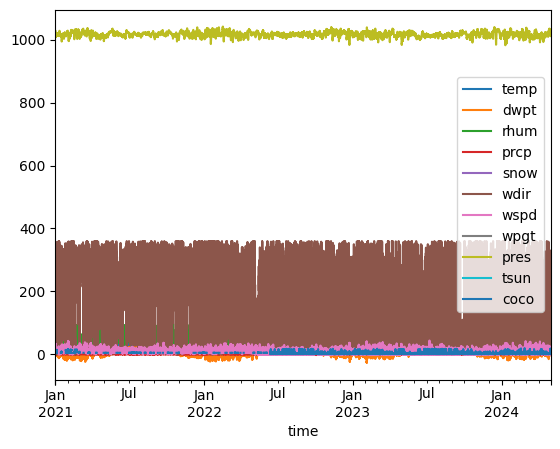

In [18]:
months = ["11"]
weather_data = get_weather_data()

weather_data_time = weather_data.reset_index().rename(columns={
    "time": "started_at_hourly"
})
#"01", "03", "07", "11", "12"
demand_hourly_all = pd.DataFrame()
return_hourly_all = pd.DataFrame()
for subdir, _, _ in os.walk(data_dir):
  # Use glob to find all CSV files in the current directory
  csv_files = glob.glob(os.path.join(subdir, '*.csv'))

  # Read each CSV file and store the dataframe in the list
  for file in csv_files:
    if "2022" not in file and "citibike" in file: #and any(month in file for month in months):
      print(file)
      df = pd.read_csv(file)


      print(df.shape)
      manhattan_df = df[df.apply(lambda row: is_in_manhattan(
          row['end_lat'],
          row['end_lng'],
          manhattan_polygon), axis=1)]

      manhattan_df = manhattan_df[manhattan_df.apply(lambda row: is_in_manhattan(
          row['start_lat'],
          row['start_lng'],
          manhattan_polygon), axis=1)]

      demand_hourly, demand_hourly_overall, return_hourly, return_hourly_overall = aggregate_data(manhattan_df)

      demand_hourly_all = pd.concat([demand_hourly_all, demand_hourly])
      return_hourly_all = pd.concat([return_hourly_all, return_hourly])

In [19]:
demand_hourly_all

,start_station_id,started_at_year,started_at_month,started_at_day,started_at_hour,demand,duration_sec,started_at_week,started_at_quarter,started_at_dayofweek,is_holiday,started_at_hourly,started_at_daily
0,3879.04,2024,1,5,10,2,428.0,1,1,4,True,2024-01-05 10:00:00,2024-01-05
1,4846.01,2024,1,5,5,4,194.0,1,1,4,True,2024-01-05 05:00:00,2024-01-05
2,4846.01,2024,1,5,7,14,771.0,1,1,4,True,2024-01-05 07:00:00,2024-01-05
3,4846.01,2024,1,5,8,4,735.0,1,1,4,True,2024-01-05 08:00:00,2024-01-05
4,4846.01,2024,1,5,9,8,756.5,1,1,4,True,2024-01-05 09:00:00,2024-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
220114,8665.09,2023,5,31,13,4,142.0,22,2,2,True,2023-05-31 13:00:00,2023-05-31
220115,8665.09,2023,5,31,16,4,2032.0,22,2,2,True,2023-05-31 16:00:00,2023-05-31
220116,8665.09,2023,5,31,18,4,129.0,22,2,2,True,2023-05-31 18:00:00,2023-05-31
220117,8665.09,2023,5,31,20,4,1175.0,22,2,2,True,2023-05-31 20:00:00,2023-05-31


In [20]:
demand_hourly_all.to_csv(data_dir+"demand_hourly_all.csv")
return_hourly_all.to_csv(data_dir+"return_hourly_all.csv")

In [25]:
manhattan_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629173 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             629173 non-null  object        
 1   rideable_type       629173 non-null  object        
 2   started_at          629173 non-null  datetime64[ns]
 3   ended_at            629173 non-null  datetime64[ns]
 4   start_station_name  629173 non-null  object        
 5   start_station_id    629173 non-null  float64       
 6   end_station_name    629173 non-null  object        
 7   end_station_id      629173 non-null  object        
 8   start_lat           629173 non-null  float64       
 9   start_lng           629173 non-null  float64       
 10  end_lat             629173 non-null  float64       
 11  end_lng             629173 non-null  float64       
 12  member_casual       629173 non-null  object        
 13  duration_sec        629173 non-nul

In [23]:
sorted_df = demand_hourly_all.groupby("started_at_daily")['demand'].sum().reset_index()
fig = px.line(sorted_df, x="started_at_daily", y="demand", title=f'Daily Demand Overall')
fig.update_layout(hovermode="x")
fig.show()


In [27]:
sorted_df = return_hourly_all.groupby("ended_at_daily")['bike_return'].sum().reset_index()
fig = px.line(sorted_df, x="ended_at_daily", y="bike_return", title=f'Daily Return Overall')
fig.update_layout(hovermode="x")
fig.show()


In [25]:
return_hourly_all

,end_station_id,ended_at_year,ended_at_month,ended_at_day,ended_at_hour,bike_return,duration_sec,ended_at_week,ended_at_quarter,ended_at_dayofweek,is_holiday,ended_at_hourly,ended_at_daily
0,4846.01,2024,1,1,1,4,1459.000000,1,1,0,True,2024-01-01 01:00:00,2024-01-01
1,4846.01,2024,1,1,3,4,1036.000000,1,1,0,True,2024-01-01 03:00:00,2024-01-01
2,4846.01,2024,1,1,10,4,1231.000000,1,1,0,True,2024-01-01 10:00:00,2024-01-01
3,4846.01,2024,1,1,11,20,1785.200000,1,1,0,True,2024-01-01 11:00:00,2024-01-01
4,4846.01,2024,1,1,13,12,1224.333333,1,1,0,True,2024-01-01 13:00:00,2024-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102054,7855.03,2023,6,1,0,4,355.000000,22,2,3,True,2023-06-01 00:00:00,2023-06-01
102055,7959.18,2023,6,1,0,4,3131.000000,22,2,3,True,2023-06-01 00:00:00,2023-06-01
102056,8054.04,2023,6,1,0,4,3732.000000,22,2,3,True,2023-06-01 00:00:00,2023-06-01
102057,8157.06,2023,6,1,0,4,1411.000000,22,2,3,True,2023-06-01 00:00:00,2023-06-01


In [ ]:
demand_hourly = demand_hourly.merge(standard_stations[['station_id', 'clusters']].rename(columns={
    "station_id":'start_station_id'}), on=["start_station_id"])

weather_data_time = weather_data.reset_index().rename(columns={
    "time": "started_at_hourly"
})
demand_hourly = demand_hourly.merge(weather_data_time[['temp', 'dwpt', "rhum", "prcp", "wdir", "wspd", "pres", "coco", "centroid", 'started_at_hourly']].rename(columns={
    "centroid":"clusters"
}), on=['clusters', "started_at_hourly"])

In [ ]:
standard_stations.to_csv("/content/drive/MyDrive/Colab Notebooks/GBDS_Project/processed_data/standard_stations.csv")#.info()

In [ ]:
demand_hourly.to_csv("/content/drive/MyDrive/Colab Notebooks/GBDS_Project/processed_data/pre_processed_data.csv")#.info()

In [ ]:
weather_data_time['started_at_hourly'].max()

Timestamp('2024-04-15 18:00:00')

In [ ]:
demand_hourly

,start_station_id,started_at_year,started_at_month,started_at_day,started_at_hour,demand,duration_sec,started_at_week,started_at_quarter,started_at_dayofweek,...,started_at_daily,clusters,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
0,4040 3rd St Depot Station,2022,7,15,22,1,1389.000000,28,3,4,...,2022-07-15,1,18.3,11.1,63.0,0.0,290.0,40.7,1015.4,2.0
1,SF-A20,2022,7,15,22,1,611.000000,28,3,4,...,2022-07-15,1,18.3,11.1,63.0,0.0,290.0,40.7,1015.4,2.0
2,SF-A25,2022,7,15,22,1,604.000000,28,3,4,...,2022-07-15,1,18.3,11.1,63.0,0.0,290.0,40.7,1015.4,2.0
3,SF-C20-2,2022,7,15,22,3,1156.333333,28,3,4,...,2022-07-15,1,18.3,11.1,63.0,0.0,290.0,40.7,1015.4,2.0
4,SF-C21,2022,7,15,22,1,1145.000000,28,3,4,...,2022-07-15,1,18.3,11.1,63.0,0.0,290.0,40.7,1015.4,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3350535,OK-H3,2021,3,19,3,1,690.000000,11,1,4,...,2021-03-19,2,13.9,11.1,83.0,0.0,170.0,13.0,1019.8,7.0
3350536,OK-H3,2022,3,17,5,1,1074.000000,11,1,3,...,2022-03-17,2,11.1,7.8,80.0,0.0,280.0,22.3,1023.0,2.0
3350537,OK-M14,2022,6,20,2,2,1679.500000,25,2,0,...,2022-06-20,2,17.2,10.1,63.0,0.0,270.0,20.5,1017.7,1.0
3350538,OK-M14,2022,11,7,4,1,1616.000000,45,4,0,...,2022-11-07,2,12.8,8.9,77.0,0.0,200.0,20.5,1009.5,3.0
